__Урок 6. Градиентный бустинг (AdaBoost)__

__Задание 1:__<br> Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [10]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array(
        [sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X]
    )

# В качестве функционала ошибки будем использовать среднеквадратичную ошибку. 
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    # Деревья будем записывать в список
    trees = []   
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

    
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

    
def get_train_mse(X_train, y_train, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_pred_mse = mean_squared_error(y_train, train_prediction)
    return train_pred_mse
    
def get_test_mse(X_test, y_test, trees, coefs, eta):    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    tst_pred_mse = mean_squared_error(y_test, test_prediction) 
    return tst_pred_mse

def get_plot_by_n_trees(X_train, X_test, y_train, y_test, n_trees, max_depth, eta):
    train_pred_mse = []
    tst_pred_mse = []
    for i in n_trees:   
        coefs = [1] * i     # для простоты примем коэффициенты равными 1
        trees, train_errors, test_errors = gb_fit(i, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_pred_mse.append( get_train_mse(X_train, y_train, trees, coefs, eta) )
        tst_pred_mse.append( get_test_mse(X_test, y_test, trees, coefs, eta) )
        
    plt.title('Зависимость  MSE от числа деревьев')
    plt.xlabel('число деревьев')
    plt.ylabel('MSE')
    plt.plot(n_trees, train_pred_mse, label='train error')
    plt.plot(n_trees, tst_pred_mse, label='test error')
    plt.legend(loc='best')
    plt.show()
   
    

In [76]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

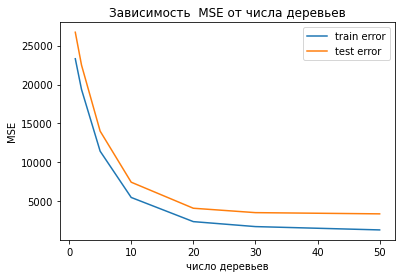

In [77]:
# Число деревьев в ансамбле
n_trees = [ 1, 2, 5, 10, 20, 30, 50 ]
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.1

get_plot_by_n_trees(X_train, X_test, y_train, y_test, n_trees, max_depth, eta)

In [80]:
def get_plot_by_depth(X_train, X_test, y_train, y_test, n_trees, max_depth, eta):
    train_pred_mse = []
    tst_pred_mse = []
    coefs = [1] * n_trees     # для простоты примем коэффициенты равными 1
    for dpth in range(1, max_depth):   
        trees, train_errors, test_errors = gb_fit(n_trees, dpth, X_train, X_test, y_train, y_test, coefs, eta)
        train_pred_mse.append( get_train_mse(X_train, y_train, trees, coefs, eta) )
        tst_pred_mse.append( get_test_mse(X_test, y_test, trees, coefs, eta) )
        
    plt.title('Зависимость  MSE от глубины деревьев')
    plt.xlabel('глубина дерева')
    plt.ylabel('MSE')
    plt.xlim(1, len(range(max_depth-1)) )
    plt.plot(range(1, max_depth), train_pred_mse, label='train error')
    plt.plot(range(1, max_depth), tst_pred_mse, label='test error')
    plt.legend(loc='best')
    plt.show()


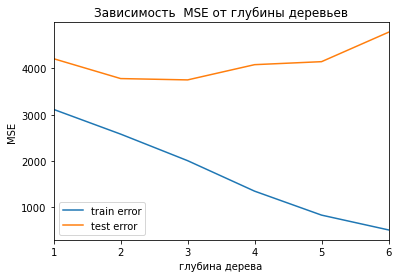

In [81]:
# Число деревьев в ансамбле
n_trees = 25
# Максимальная глубина деревьев
max_depth = 7
# Шаг
eta = 0.1

get_plot_by_depth(X_train, X_test, y_train, y_test, n_trees, max_depth, eta)

__Задание 2: (опция)__<br> Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [82]:
def gb_fit_SGB(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_num = 2):
    # Деревья будем записывать в список
    trees = []   
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    batches = np.array_split(X_train, batch_num)
    targets = np.array_split(y_train, batch_num)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        X_train_b = batches[i%batch_num]
        y_train_b = targets[i%batch_num]
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_b, y_train_b)
            
            train_errors.append(mean_squared_error(y_train_b, gb_predict(X_train_b, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_b, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_b, bias(y_train_b, target))
            
            train_errors.append(mean_squared_error(y_train_b, gb_predict(X_train_b, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors


def get_error_plot_GB_vs_SGB(X_train, X_test, y_train, y_test, n_trees=25, max_depth=3, eta=0.1):
    plt.title('error_plot_GB_vs_SGB')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    coefs = [1] * n_trees
    
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    trees_s, train_errors_s, test_errors_s = gb_fit_SGB(
        n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_num=2)
    
    plt.plot(list(range(n_trees)), test_errors, label='test error_GB')
    plt.plot(list(range(n_trees)), test_errors_s, label='test error_SGB')

    plt.legend(loc='best')
    plt.show()


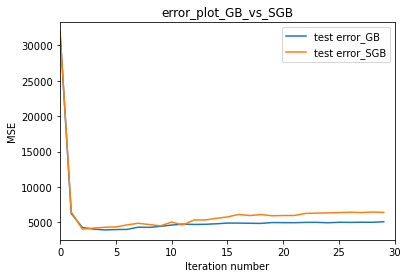

In [83]:
get_error_plot_GB_vs_SGB(X_train, X_test, y_train, y_test, n_trees=30, max_depth=3, eta=0.75)

__Задание 3: (опция)__<br> Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [30]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [31]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction                
        

In [32]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле
def split(data, labels, index, t):  
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]       
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):  
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes        

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [53]:
def gb_predict_user_tree(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array(
        [sum([eta* coef * predict(X, alg)[0] for alg, coef in zip(trees_list, coef_list)]) for x in X]
    )

# В качестве функционала ошибки будем использовать среднеквадратичную ошибку. 
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit_user_tree(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    # Деревья будем записывать в список
    trees = []   
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        #tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            #tree.fit(X_train, y_train)
            tree = build_tree(X_train, y_train)         
            
            train_errors.append(mean_squared_error(y_train, gb_predict_user_tree(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_user_tree(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict_user_tree(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict_user_tree(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict_user_tree(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

    
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

    
def get_train_mse(X_train, y_train, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_pred_mse = mean_squared_error(y_train, train_prediction)
    return train_pred_mse
    
def get_test_mse(X_test, y_test, trees, coefs, eta):    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    tst_pred_mse = mean_squared_error(y_test, test_prediction) 
    return tst_pred_mse

def get_error_plot_lib_vs_user(X_train, X_test, y_train, y_test, n_trees=25, max_depth=3, eta=0.1):
    plt.title('error_plot_DecisionTree_vs_UserTree')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    
    coefs = [1.0] * n_trees
    
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    
    trees_s, train_errors_s, test_errors_s = gb_fit_user_tree(
        n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    
    plt.plot(list(range(n_trees)), test_errors, label='test error_DecisionTree')
    plt.plot(list(range(n_trees)), test_errors_s, label='test error_UserTree')

    plt.legend(loc='best')
    plt.show()


In [54]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [55]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

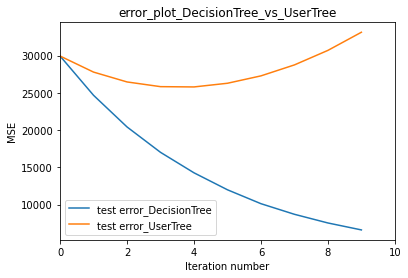

In [60]:
get_error_plot_lib_vs_user(X_train, X_test, y_train, y_test, n_trees=10, max_depth=3, eta=0.1)

При использовании дерево пользователя алгоритм гораздо медленнеее работает.
И пользовательскому дереву нужно подбирать гиперпараметры, что бы достичь качества алгоритма DecisionTreeRegressor.
Судя по графику алгоритм построенный на дереве пеользователя переобучен. 